In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')
from film import FilmSimple
from spectrum import Spectrum
from design import Design
import os

from analyze_utils.structure import plot_layer_thickness
from optimizer.adam import adam_optimize
import pickle



c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


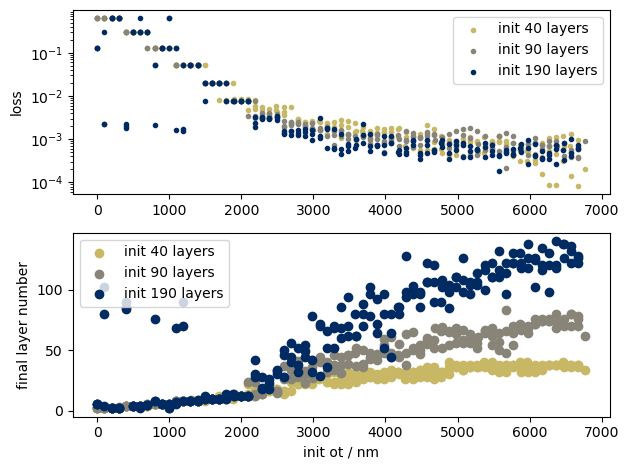

In [6]:


def load_designs(file_dir, filter=lambda x: True) -> list[Design]:
    fname_ls = os.listdir(file_dir)
    designs = []
    for fname in fname_ls:
        if not filter(fname):
            continue
        with open(file_dir + fname, 'rb') as f:
            designs.append(pickle.load(f))
    return designs




fig, (ax, ax2) = plt.subplots(2, 1)


for layer in [40, 90, 190]:

    losses = []
    init_ots = []
    final_layers = []

    dir = './raw_result/back_reflector/SiO2_TiO2-700to800nm-700nm/'
    for design in load_designs(dir, lambda x: f'_layer{layer}_' in x):
        
        design.film.remove_negative_thickness_layer()
        final_layers.append(design.film.get_layer_number())
        losses.append(design.calculate_loss())
        init_ots.append(design.get_init_ot())

        
    color = cm.get_cmap('cividis')(1 - layer / 200)

    ax.scatter(init_ots, losses, label=f'init {layer} layers', marker='.', color=color)
    ax2.scatter(init_ots, final_layers, label=f'init {layer} layers', color=color)

ax2.set_xlabel('init ot / nm')
ax.set_ylabel('loss')
ax.legend()
ax.set_yscale('log')

ax2.set_ylabel('final layer number')
ax2.legend()
fig.tight_layout()


init layer: 40
init ot: 6468.307456281747
loss: 0.00031626417115979886
init layer: 40
init ot: 6466.979276138791
loss: 0.0011606638857856982
init layer: 40
init ot: 6472.215907462458
loss: 0.000699193056212385
init layer: 40
init ot: 6567.804571437596
loss: 0.0001437180045569544
init layer: 40
init ot: 6566.455960897118
loss: 0.0006937276517871368
init layer: 40
init ot: 6571.773143387122
loss: 0.0012897207721989765
init layer: 40
init ot: 6667.301686593444
loss: 8.429007224566062e-05
init layer: 40
init ot: 6665.932645655444
loss: 0.0006874284305458642
init layer: 40
init ot: 6671.330379311788
loss: 0.0009382761557761121
init layer: 40
init ot: 6766.7988017492935
loss: 0.00020659952403595048


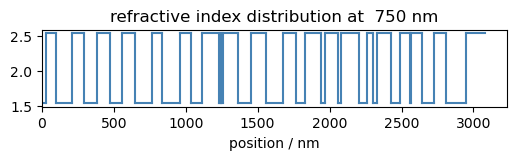

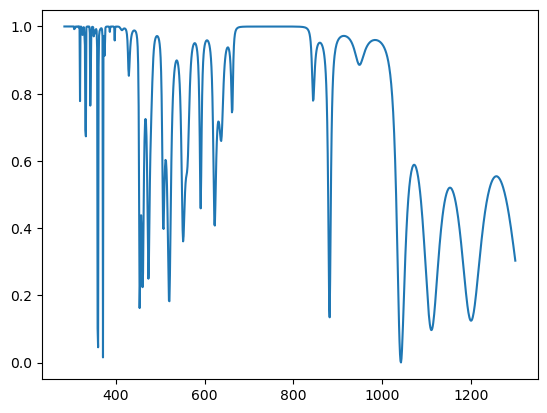

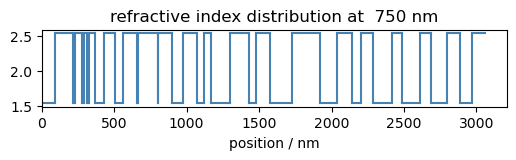

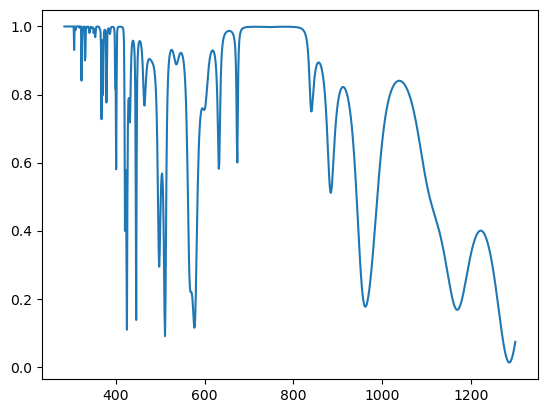

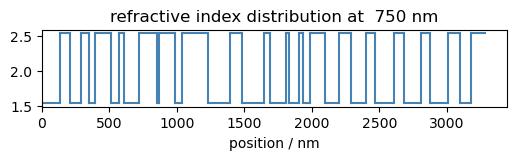

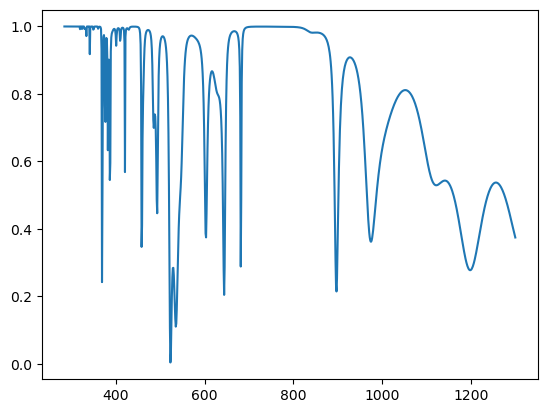

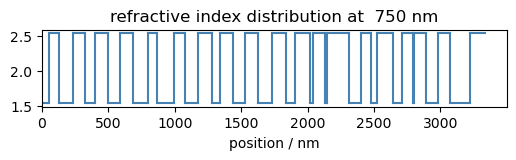

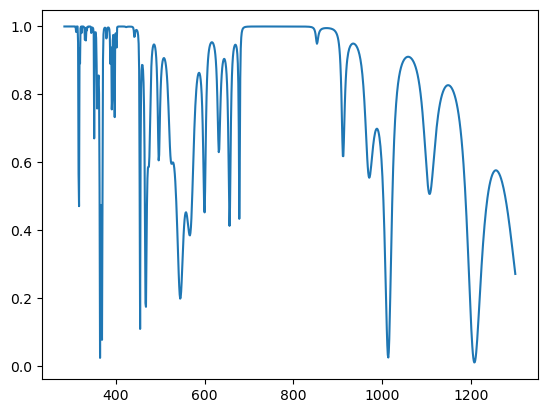

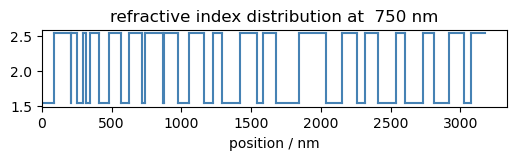

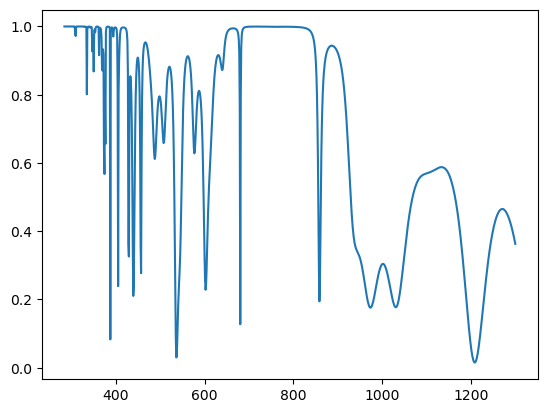

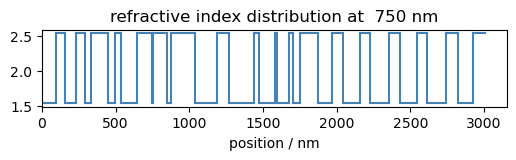

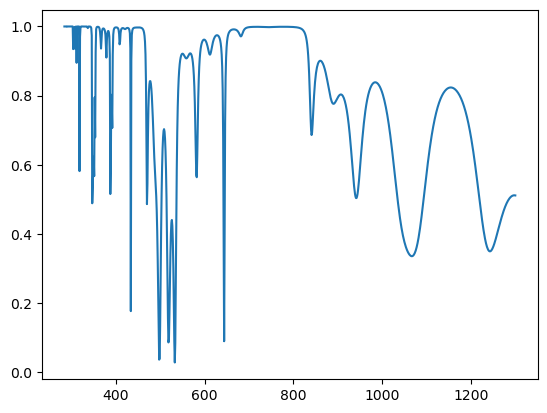

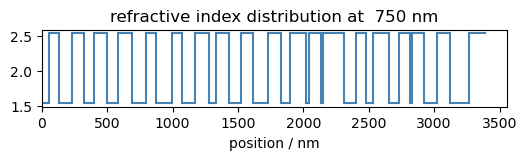

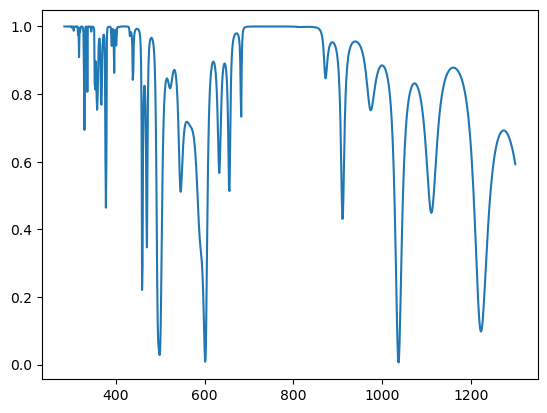

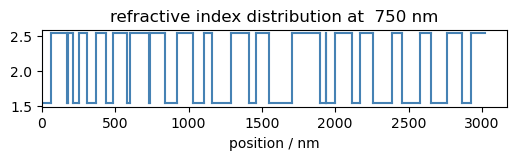

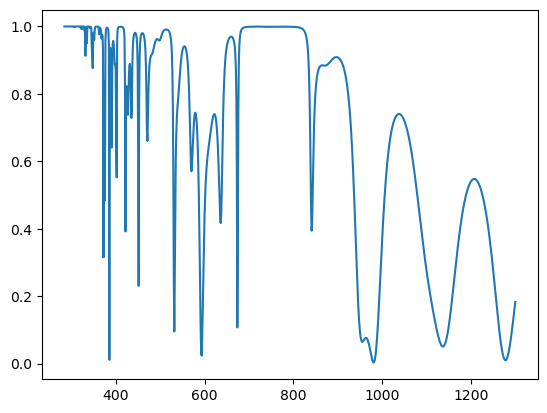

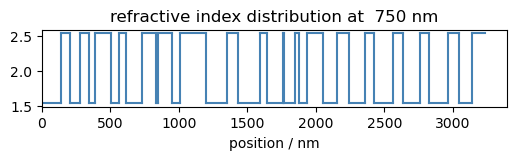

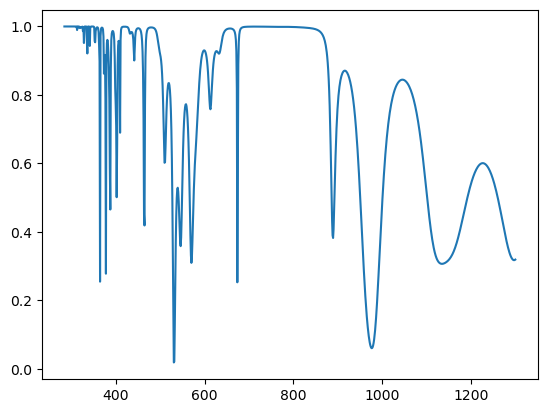

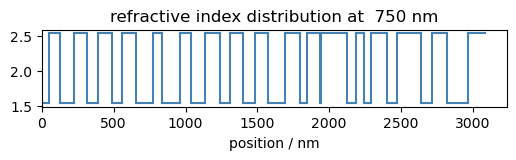

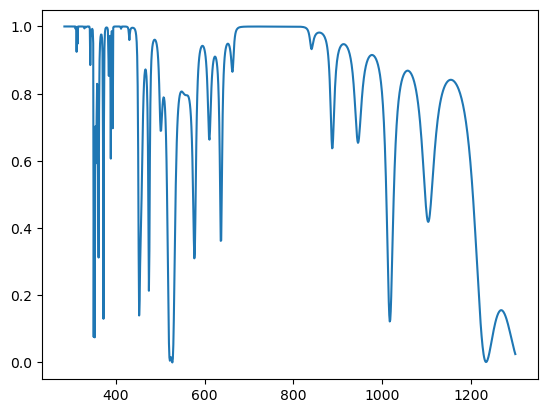

In [9]:
from analyze_utils.structure import plot_layer_thickness

def plot_deisgn(design):
    design.film.remove_negative_thickness_layer()
    print(f'init layer: {design.init_film.get_layer_number()}')
    print(f'init ot: {design.get_init_ot()}')
    print(f'loss: {design.calculate_loss()}')
    plot_layer_thickness(design.film)

dir = './raw_result/back_reflector/SiO2_TiO2-700to800nm-700nm/'
layer = 40
import re
filter = lambda x: f'_layer{layer}_' in x and 7000 > float(re.match('ot(.*)_layer', x).group(1)) > 6500
designs = load_designs(dir, filter)

for design in designs:

    plot_deisgn(design)

    fig, ax = plt.subplots(1, 1)
    wls = np.linspace(200, 1300, 1000)
    ax.plot(wls, design.film.get_spec(inc_ang=0., wls=wls).get_R())